<a href="https://colab.research.google.com/github/dwdb/tensorflow2.0-tutorial/blob/master/image/Data%20augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install -q git+https://github.com/tensorflow/docs

In [0]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

24576/17858 [=========================================] - 0s 0us/step


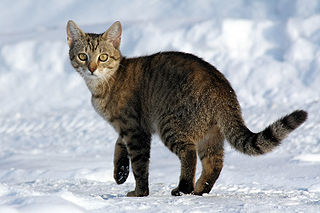

In [8]:
image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

In [0]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

In [0]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

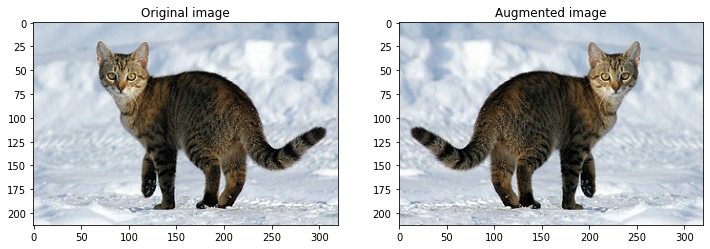

In [11]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

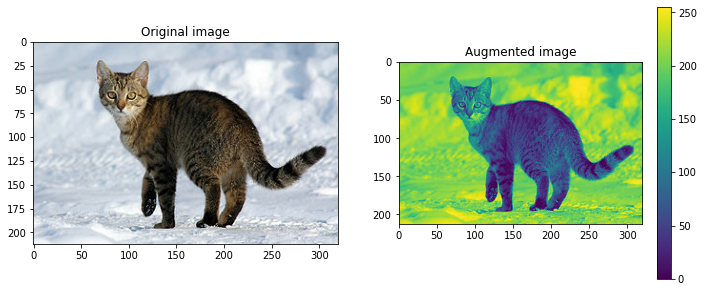

In [12]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

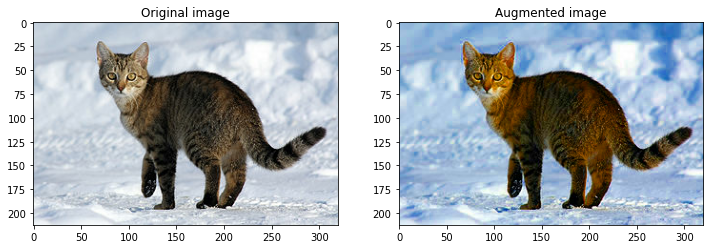

In [13]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

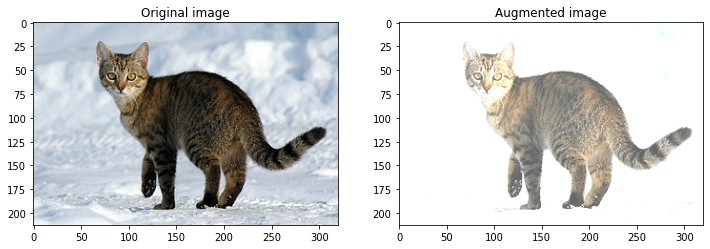

In [14]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

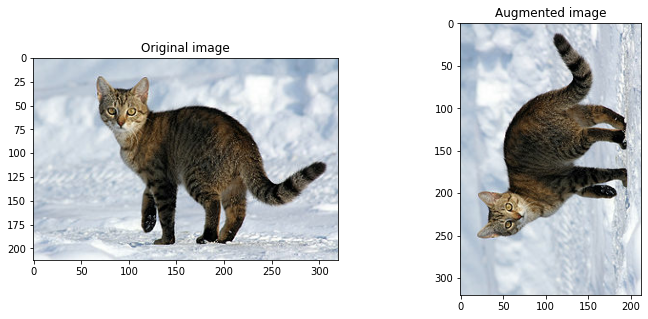

In [15]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

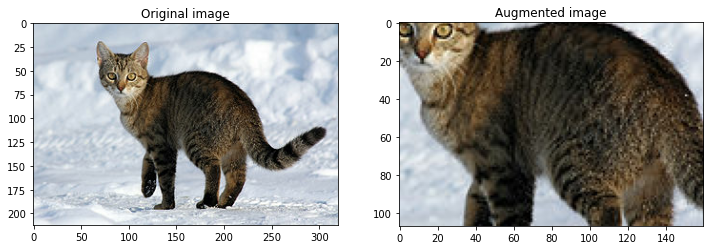

In [16]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

In [17]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label

In [0]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

In [0]:
augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [0]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [0]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [0]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [24]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 2s 71ms/step - loss: 0.7159 - accuracy: 0.7856 - val_loss: 0.4702 - val_accuracy: 0.8554
Epoch 2/50
32/32 [==============================] - 2s 67ms/step - loss: 0.1722 - accuracy: 0.9502 - val_loss: 0.2738 - val_accuracy: 0.9204
Epoch 3/50
32/32 [==============================] - 2s 67ms/step - loss: 0.0795 - accuracy: 0.9731 - val_loss: 0.3140 - val_accuracy: 0.9190
Epoch 4/50
32/32 [==============================] - 2s 68ms/step - loss: 0.0492 - accuracy: 0.9819 - val_loss: 0.2729 - val_accuracy: 0.9310
Epoch 5/50
32/32 [==============================] - 2s 67ms/step - loss: 0.0236 - accuracy: 0.9946 - val_loss: 0.3887 - val_accuracy: 0.9160
Epoch 6/50
32/32 [==============================] - 2s 66ms/step - loss: 0.0258 - accuracy: 0.9932 - val_loss: 0.3477 - val_accuracy: 0.9227
Epoch 7/50
32/32 [==============================] - 2s 67ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.3821 - val_accuracy: 0.9235
Epoch 8/50
32

In [25]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 2s 67ms/step - loss: 2.4605 - accuracy: 0.2832 - val_loss: 1.2920 - val_accuracy: 0.6709
Epoch 2/50
32/32 [==============================] - 2s 64ms/step - loss: 1.3583 - accuracy: 0.5347 - val_loss: 0.6982 - val_accuracy: 0.7845
Epoch 3/50
32/32 [==============================] - 2s 65ms/step - loss: 1.0217 - accuracy: 0.6631 - val_loss: 0.5239 - val_accuracy: 0.8590
Epoch 4/50
32/32 [==============================] - 2s 65ms/step - loss: 0.7821 - accuracy: 0.7446 - val_loss: 0.3738 - val_accuracy: 0.8961
Epoch 5/50
32/32 [==============================] - 2s 68ms/step - loss: 0.6926 - accuracy: 0.7603 - val_loss: 0.3514 - val_accuracy: 0.8971
Epoch 6/50
32/32 [==============================] - 2s 64ms/step - loss: 0.6476 - accuracy: 0.7866 - val_loss: 0.3086 - val_accuracy: 0.9074
Epoch 7/50
32/32 [==============================] - 2s 68ms/step - loss: 0.5350 - accuracy: 0.8257 - val_loss: 0.2901 - val_accuracy: 0.9074
Epoch 8/50
32

(0.75, 1.0)

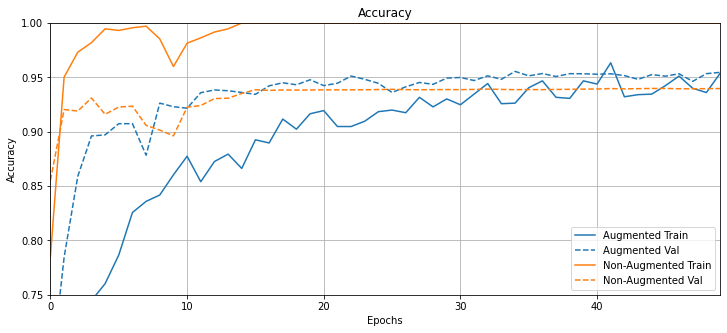

In [26]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])

(0.0, 1.0)

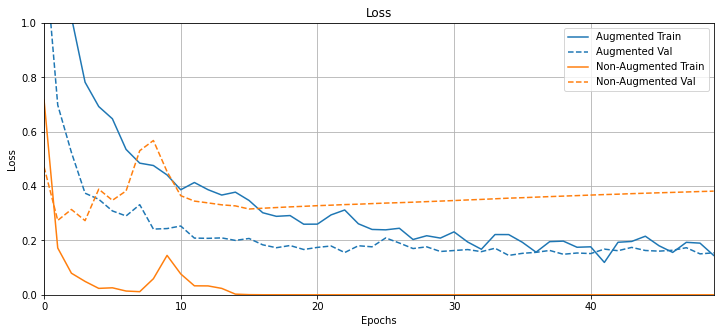

In [27]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])